In [1]:
import torch
from torchvision import transforms
import random
#sets random
random_seed=42
random.seed(42)
torch.manual_seed(random_seed)

device="cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu" )

match device:
    case "cuda":
        torch.cuda.manual_seed_all(random_seed)
    case "mps":
        torch.mps.manual_seed(random_seed)

### Inference Segmenter

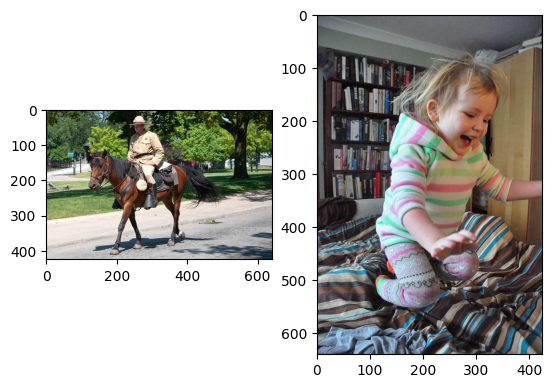

In [2]:
import matplotlib.pyplot as plt
import cv2
import data_utils.dataset as ds
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation
import numpy as np

# load MaskFormer fine-tuned on COCO panoptic segmentation
feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-large-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-large-coco")

batch_size = 2

#read and transform images
image = cv2.imread("datasets/images/train2014/COCO_train2014_000000002056.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image2 = cv2.imread("datasets/images/train2014/COCO_train2014_000000005219.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(image2)


In [3]:
def extract_segments(seg_mask: torch.Tensor, seg_info: list[dict], image: torch.Tensor) -> torch.Tensor:
    """
    Extracting segments from given image corresponding segmentation mask
    """
    #creating and concating maps for each class, reshaping [height, width] -> [1, height, width] 
    class_maps = torch.cat([seg_mask[None, :, :] == value['id'] for value in seg_info], dim=0)
    class_maps = class_maps.to(torch.uint8)

    # edding extra dimension for extracting from image [seg_mask_for_class, height, width] -> [seg_mask_for_class, chnnels ,height, width]
    class_maps = class_maps[:, None, :, :]
    class_maps = class_maps.repeat(1, 3, 1, 1)
    extracted_segments = image * class_maps
    return extracted_segments

In [4]:
image.shape, image2.shape

((425, 640, 3), (640, 425, 3))

In [5]:
transformed_image = ds.affine_transform(image, (480, 640))
transformed_image2 = ds.affine_transform(image2, (480, 640))


In [6]:
transformed_image.shape, transformed_image2.shape

((480, 640, 3), (480, 640, 3))

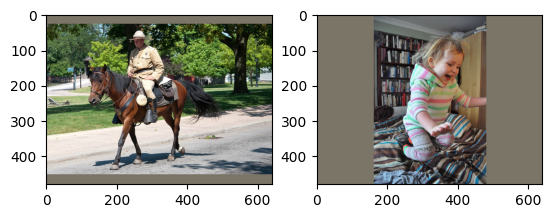

In [7]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(transformed_image)
axs[1].imshow(transformed_image2)

In [8]:
transformed_image.shape

(480, 640, 3)

In [9]:
tensor_img = torch.from_numpy(transformed_image.transpose(2, 0, 1))
tensor_img2 = torch.from_numpy(transformed_image2.transpose(2, 0, 1))

In [10]:
tensor_img[None, :, :, :].size()

torch.Size([1, 3, 480, 640])

In [11]:
batch_size = 2

#Если нужно ручками батч прокинуть
batch = torch.concat((tensor_img, tensor_img2)).view(batch_size, 3, 480, 640)

inputs = feature_extractor(images=batch, return_tensors="pt", do_rescale=False)
outputs = model(**inputs)

#если нужны данные до предобработки
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits


result = feature_extractor.post_process_panoptic_segmentation(outputs, target_sizes=[batch.size()[2:]]*batch_size)

masks = [extract_segments(result[i]['segmentation'], result[i]['segments_info'], batch[i]) for i in range(batch_size)]

`label_ids_to_fuse` unset. No instance will be fused.


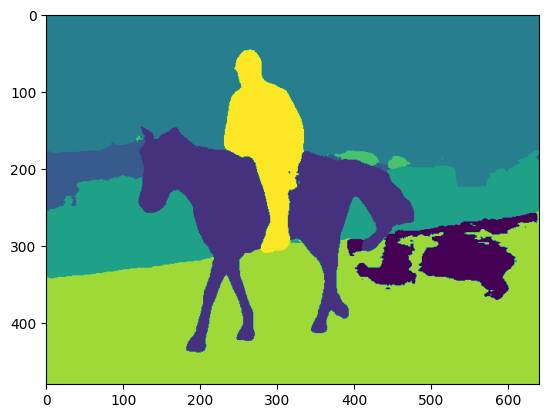

In [12]:
ax = plt.gca()
ax.imshow(result[0]['segmentation'])

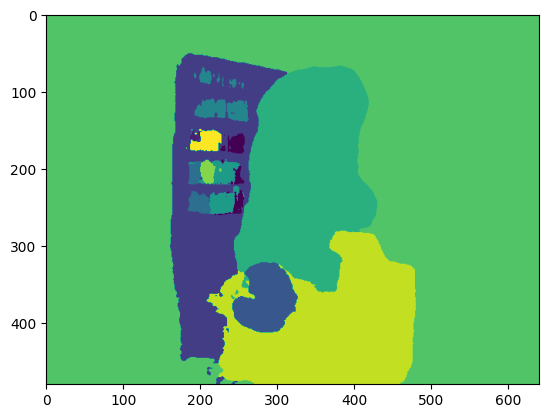

In [13]:
ax = plt.gca()
ax.imshow(result[1]['segmentation'])

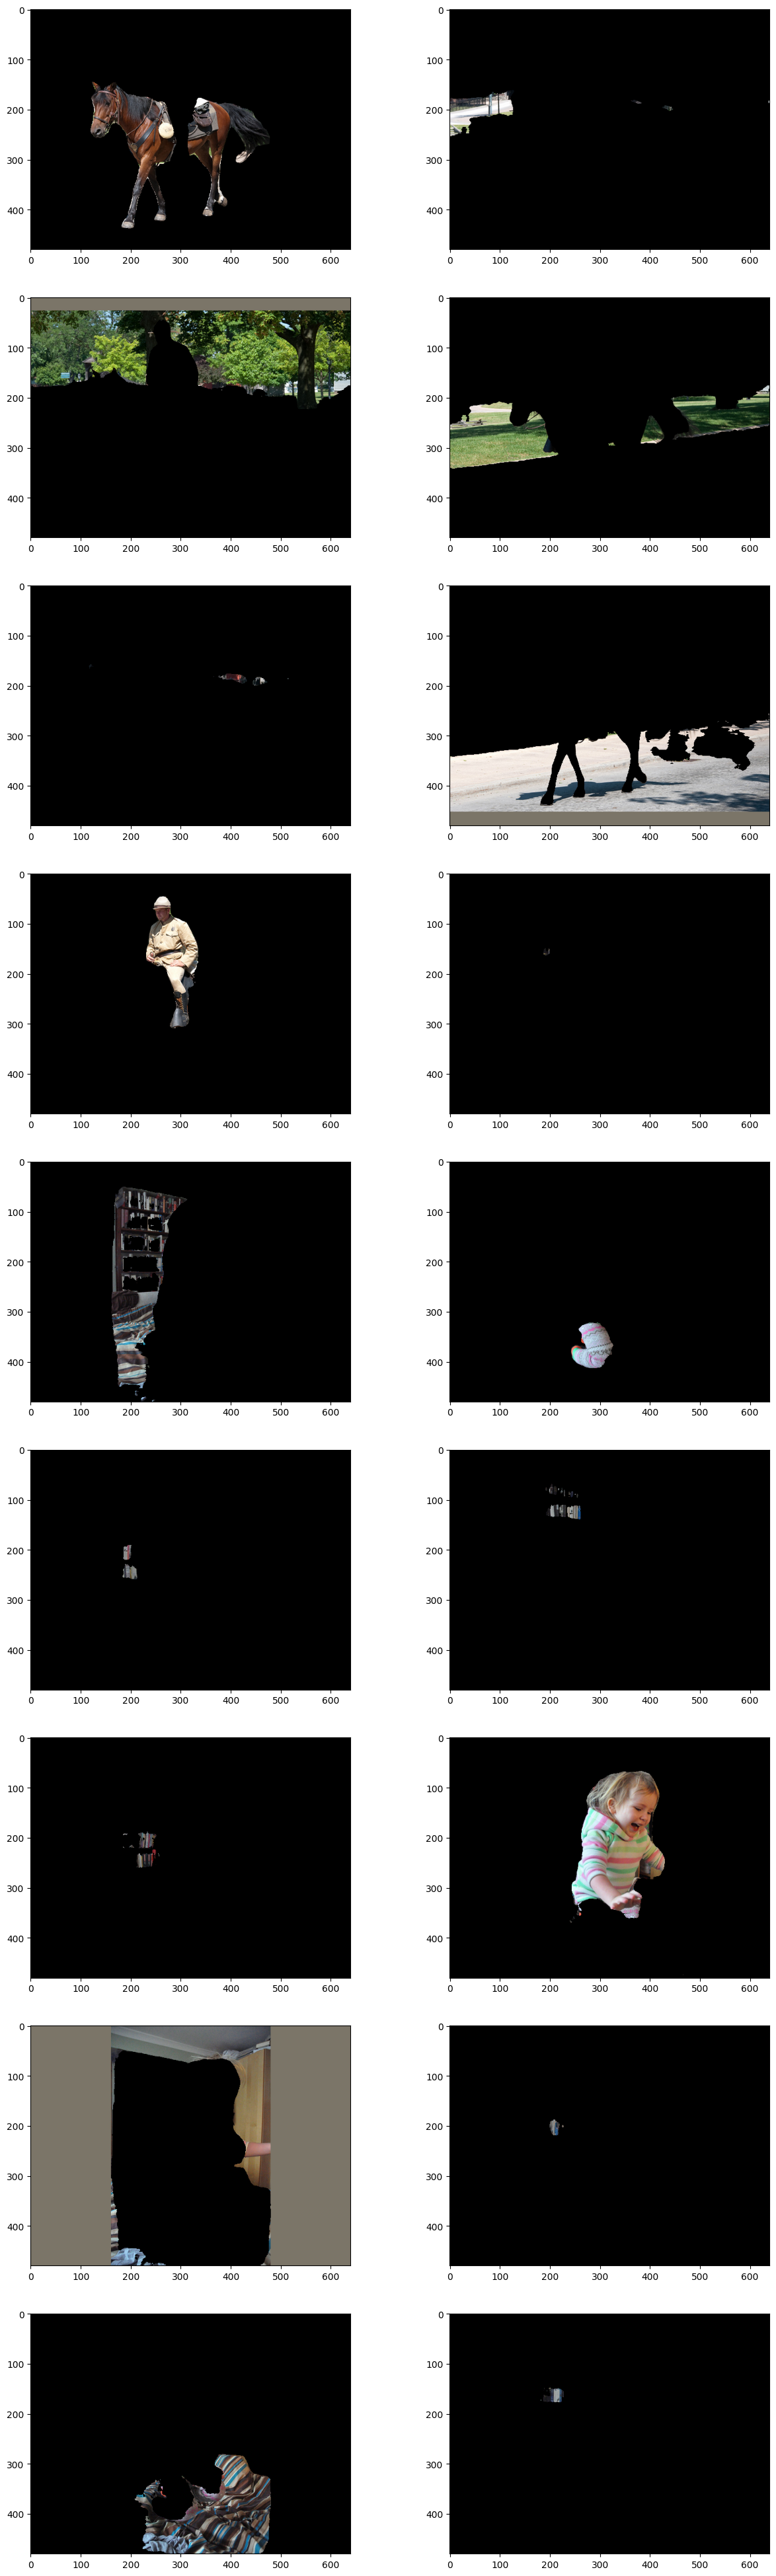

In [14]:
lens = [len(m) for m in masks]
s = sum(lens)
fig, axs = plt.subplots(int(np.ceil(s / 2)), 2, figsize = (15, 50))
i = 0
j = 0
for mask_group in masks:
    for mask in mask_group:
        axs[i, j].imshow(mask.permute(1, 2, 0))
        if (j + 1) % 2 == 0:
            i += 1
            j = 0
        else:
            j += 1

### Test

In [15]:
from model.vit import StageOneEncoder
from utils.checkpoints import load_checkpoint
from model.bert import TextEmbedding
from data_utils import tokenizer
#sets random

In [16]:
embeder_model, optimizer, scheduler, conf, loss, val_acc = load_checkpoint('stage_one', 'epoch_41', device=device)

In [17]:
text_model = TextEmbedding(conf['model']['text_backbone'], pool=True)
bert_tokenizer = tokenizer.get_auto_tokenizer(conf['model']['text_backbone'])

In [ ]:
def l2(x, y):
    return torch.norm(x - y, dim=1)

In [18]:
def sim(x, y):
    return torch.nn.functional.cosine_similarity(x, y)

In [77]:
sentence = "Horse"
tokens, mask = bert_tokenizer.tokenize(sentence)
output = text_model(tokens, mask)
result,_ = embeder_model(masks[1].to(torch.float32).to(device))


In [78]:
sentence = "Police officer"
tokens2, mask2 = bert_tokenizer.tokenize(sentence)
output2 = text_model(tokens2, mask2)

In [79]:
sim(output, output2)

tensor([0.9122])

In [51]:
mx = torch.argmax(sim(result.detach().cpu(), output))
my = torch.argmin(l2(result.detach().cpu() , output))

In [25]:
pairs = torch.stack((sim(result.detach().cpu(), output), l2(result.detach().cpu(), output))).T.view(-1, 2)

In [26]:
pairs

tensor([[ 0.9207, 61.3329],
        [ 0.9462, 58.7124],
        [ 0.9374, 59.7253],
        [ 0.9307, 62.1033],
        [ 0.9143, 60.0179],
        [ 0.9262, 57.4353],
        [ 0.9346, 71.7072],
        [ 0.9376, 70.5288],
        [ 0.9288, 59.4407],
        [ 0.9341, 58.4643],
        [ 0.9310, 57.7620]])

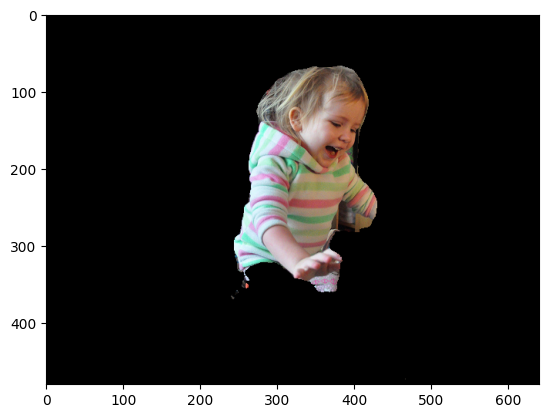

In [52]:
ax = plt.gca()
ax.imshow(masks[1][mx.item()].permute(1, 2, 0))

In [1]:
import torch

In [16]:
a = torch.ones(3, 1)
b = torch.ones(2, 10, 3)
probs = torch.matmul(b, a).transpose(-2, -1)
probs.size()

torch.Size([2, 1, 10])

In [21]:
torch.matmul(probs, b).squeeze(-2).size()

torch.Size([2, 3])